In [76]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from lib.models import ConvLayerNorm, Block
import matplotlib.pyplot as plt

data = []
from tqdm import tqdm

experiments_dir = f'./experiments'

for experiment in tqdm(os.listdir(experiments_dir)):
    base_f1s = []
    target_f1s = []
    folds = []

    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/metrics.json'):
            continue
        metrics = json.load(open(f'{experiments_dir}/{experiment}/{run}/metrics.json'))
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        data.append({
            'batch_size': hyperparameters['batch_size'], 
            'fold': run, 
            'best_custom_model_on_target_val_f1': metrics['best_target_model_target_val_f1'], 
            'best_custom_model_on_target_test_f1': metrics['best_target_model_target_test_f1'], 
            'mode': hyperparameters['mode'], 
            'target_data_pct': hyperparameters['target_data_pct'], 
            'best_custom_model_on_target_val_loss': metrics['best_target_model_target_val_loss'],
            'best_custom_model_on_target_test_loss': metrics['best_target_model_target_test_loss'],
            'n_base_participants': hyperparameters['n_base_participants'],
        })
        
df = pd.DataFrame(data)

100%|██████████| 74/74 [00:00<00:00, 441.48it/s]


In [77]:
print(df['mode'].value_counts())
print(df['target_data_pct'].value_counts())
print(df['batch_size'].value_counts())

mode
target_only         504
full_fine_tuning      8
Name: count, dtype: int64
target_data_pct
0.010    92
1.000    84
0.050    84
0.125    84
0.500    84
0.250    84
Name: count, dtype: int64
batch_size
32    260
64    252
Name: count, dtype: int64


<Axes: xlabel='batch_size', ylabel='best_custom_model_on_target_val_loss'>

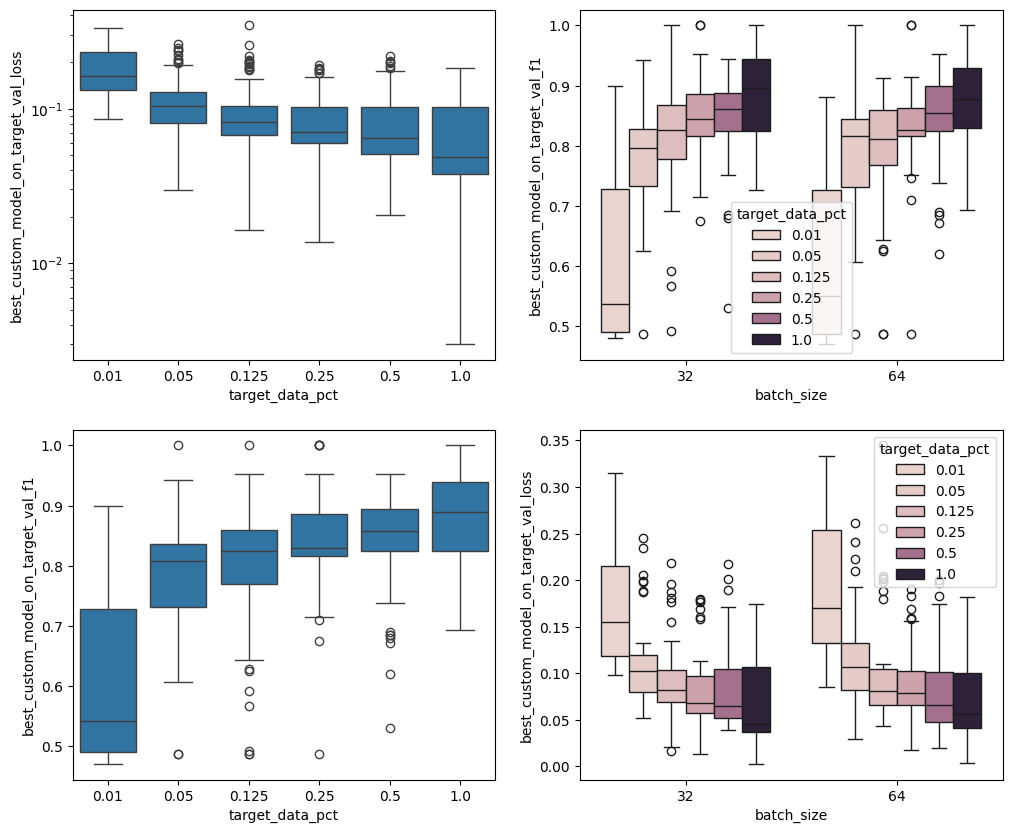

In [51]:
fig,ax = plt.subplots(2,2, figsize=(12,10))
sns.boxplot(data=df, x='target_data_pct', y='best_custom_model_on_target_val_loss', ax=ax[0,0])
ax[0,0].set_yscale('log')
sns.boxplot(data=df, x='target_data_pct', y='best_custom_model_on_target_val_f1', ax=ax[1,0])
sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', hue='target_data_pct', ax=ax[0,1])
sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', hue='target_data_pct', ax=ax[1,1])

<Axes: xlabel='mode', ylabel='best_custom_model_on_target_test_f1'>

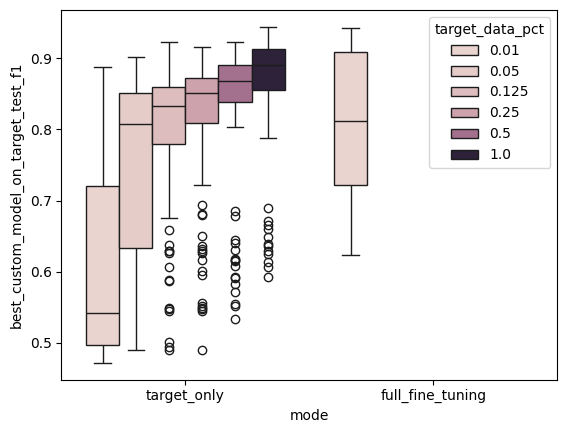

In [79]:
sns.boxplot(data=df, x='mode', y='best_custom_model_on_target_test_f1', hue='target_data_pct')

In [84]:
df[df['mode'] == 'full_fine_tuning']

,batch_size,fold,best_custom_model_on_target_val_f1,best_custom_model_on_target_test_f1,mode,target_data_pct,best_custom_model_on_target_val_loss,best_custom_model_on_target_test_loss,n_base_participants
245,32,fold0_tonmoy,0.874162,0.623159,full_fine_tuning,0.01,0.077113,0.423408,2
421,32,fold4_ejaz,1.000000,0.943401,full_fine_tuning,0.01,0.004916,0.018187,1
422,32,fold1_asfik,0.928500,0.906322,full_fine_tuning,0.01,0.054484,0.070024,1
423,32,fold3_anam,0.847280,0.738949,full_fine_tuning,0.01,0.144320,0.111576,1
424,32,fold6_unk1,0.925346,0.916197,full_fine_tuning,0.01,0.047436,0.043402,1
425,32,fold5_iftakhar,0.850788,0.863685,full_fine_tuning,0.01,0.050406,0.039190,1
426,32,fold0_tonmoy,0.881830,0.672770,full_fine_tuning,0.01,0.074244,0.180404,1
427,32,fold2_alsaad,0.884526,0.759293,full_fine_tuning,0.01,0.058377,0.102381,1


<Axes: xlabel='mode', ylabel='best_custom_model_on_target_test_f1'>

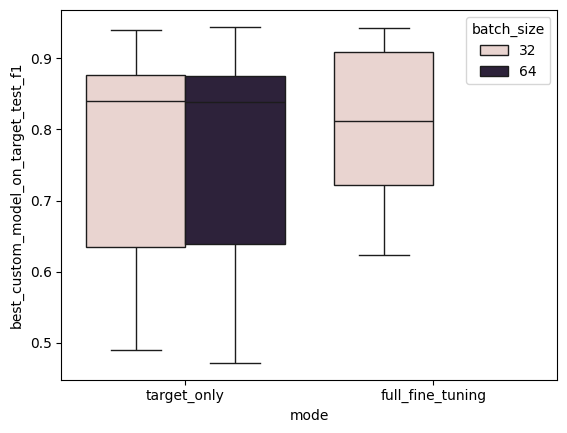

In [80]:
sns.boxplot(data=df, x='mode', y='best_custom_model_on_target_test_f1', hue='batch_size')

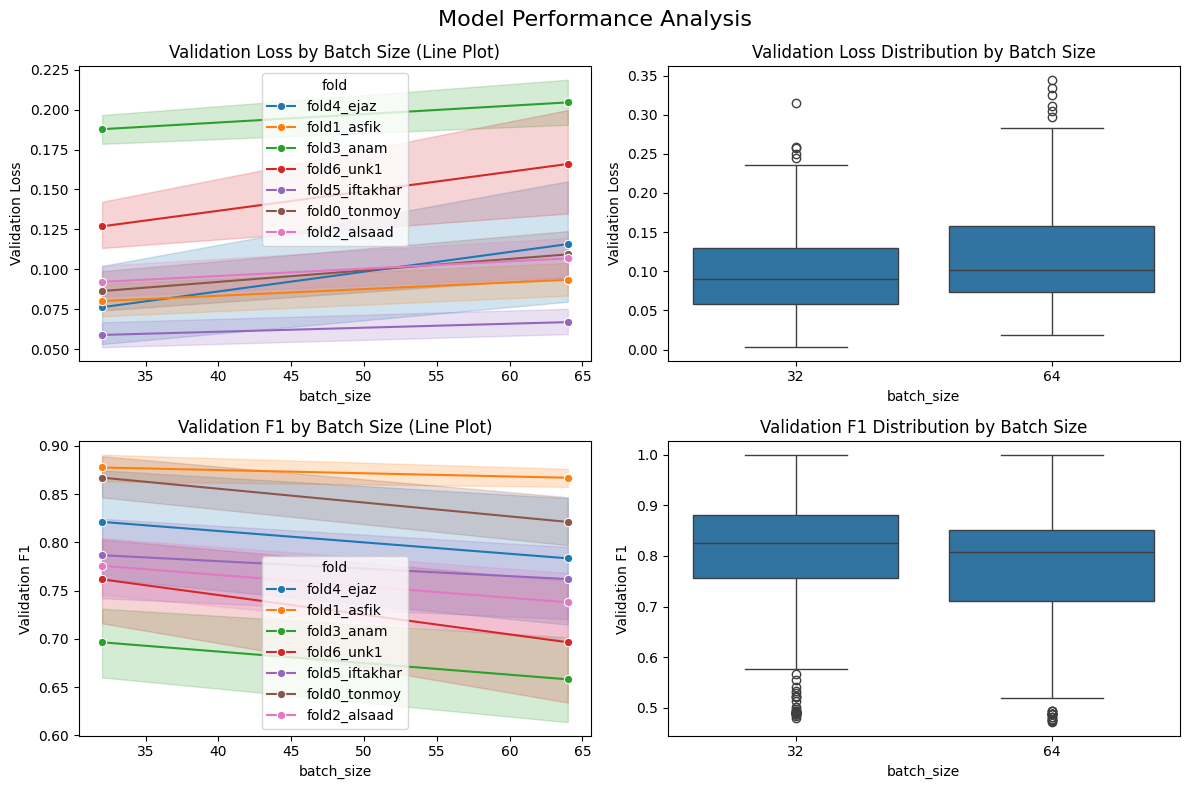

100%|██████████| 62/62 [00:00<00:00, 439.61it/s]


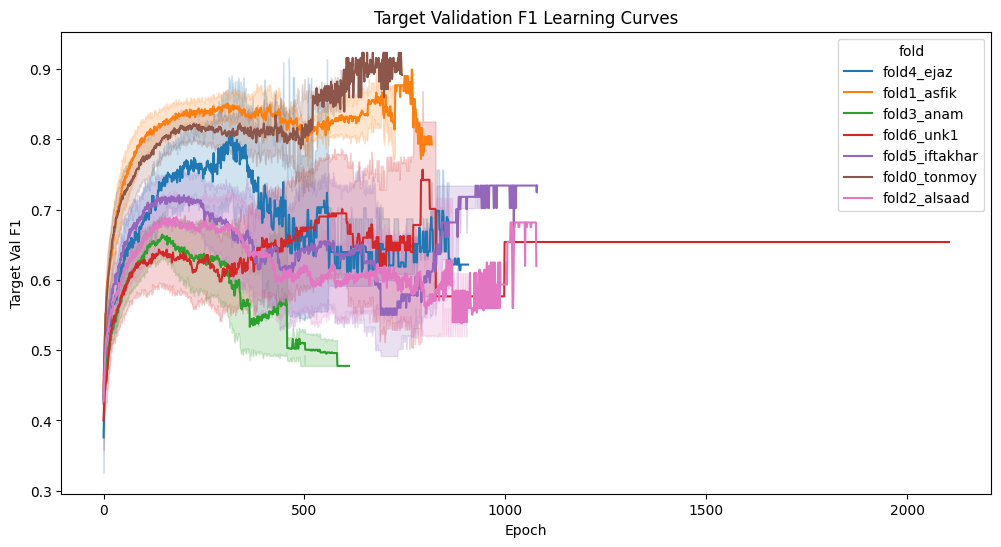

In [3]:
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Model Performance Analysis', fontsize=16)

# Loss plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', 
             hue='fold', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Validation Loss by Batch Size (Line Plot)')
axes[0, 0].set_ylabel('Validation Loss')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', ax=axes[0, 1])
axes[0, 1].set_title('Validation Loss Distribution by Batch Size')
axes[0, 1].set_ylabel('Validation Loss')

# F1 plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', 
             hue='fold', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Validation F1 by Batch Size (Line Plot)')
axes[1, 0].set_ylabel('Validation F1')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', ax=axes[1, 1])
axes[1, 1].set_title('Validation F1 Distribution by Batch Size')
axes[1, 1].set_ylabel('Validation F1')

plt.tight_layout()
plt.show()

# Target val f1 learning curves
curve_data = []
for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/losses.json'):
            continue
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))

        for epoch, f1 in enumerate(losses['target val f1']):
            curve_data.append({
                'epoch': epoch,
                'target_val_f1': f1,
                'fold': run
            })

curve_df = pd.DataFrame(curve_data)
plt.figure(figsize=(12, 6))
sns.lineplot(data=curve_df, x='epoch', y='target_val_f1', hue='fold')
plt.title('Target Validation F1 Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Target Val F1')
plt.show()


<Axes: xlabel='n_base_participants', ylabel='best_target_model_target_test_f1'>

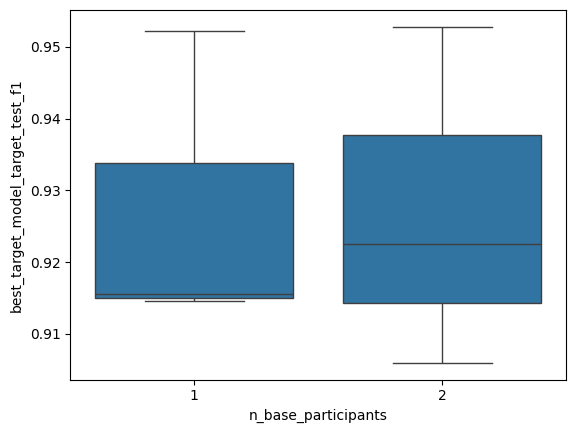

In [64]:
sns.boxplot(data=df, x='n_base_participants', y='best_target_model_target_test_f1')

<Axes: xlabel='n_base_participants', ylabel='best_target_model_target_test_f1'>

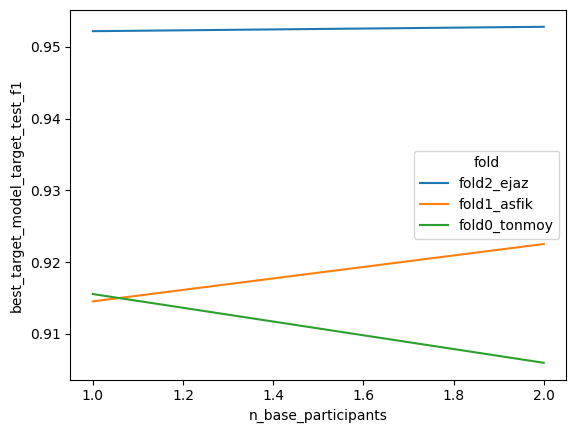

In [66]:
sns.lineplot(data=df, x='n_base_participants', y='best_target_model_target_test_f1',hue='fold')


In [ ]:

display(df)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Model Performance Analysis', fontsize=16)

# Loss plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', 
             hue='fold', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Validation Loss by Batch Size (Line Plot)')
axes[0, 0].set_ylabel('Validation Loss')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', ax=axes[0, 1])
axes[0, 1].set_title('Validation Loss Distribution by Batch Size')
axes[0, 1].set_ylabel('Validation Loss')

# F1 plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', 
             hue='fold', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Validation F1 by Batch Size (Line Plot)')
axes[1, 0].set_ylabel('Validation F1')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', ax=axes[1, 1])
axes[1, 1].set_title('Validation F1 Distribution by Batch Size')
axes[1, 1].set_ylabel('Validation F1')

plt.tight_layout()
plt.show()
